In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from Network import GraphNet
from IRM_generative_torch import IRM_graph, clusterIndex
from IRM_post import Cmatrix_to_array, torch_posterior

# Giver samtlige mulige clusterings i form af
# nul-indekserede cluster arrays.
def allPermutations(n):
    perm = [[[1]]]
    for i in range(n-1):
        perm.append([])
        for partial in perm[i]:
            for j in range(1, max(partial) + 2):
                perm[i + 1].append(partial + [j])

    return np.array(perm[-1])-1


tensor([0., 0., 0., 1., 1., 2., 2., 3., 4., 5.])


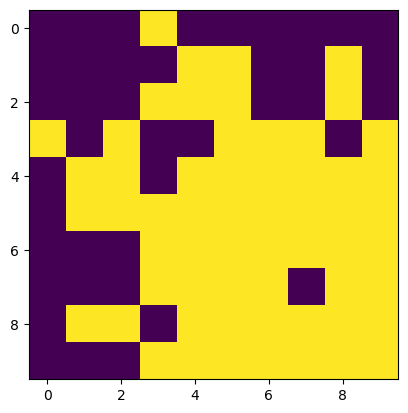

In [45]:
# Making the graph, and outputting cluster indexes.
N =  10
adjacency_matrix, clusters = IRM_graph(3, 0.5, 0.5, N = N)
cluster_idxs = clusterIndex(clusters)
plt.imshow(adjacency_matrix)
print(cluster_idxs)

In [46]:
# Computing posteriors for all clusters.
clusters_all = allPermutations(N)
clusters_all_post = []
for cluster in clusters_all:
    posterior = (torch_posterior(adjacency_matrix, cluster, a=torch.tensor([0.5]), b=torch.tensor([0.5]), alpha = 3, log=True))
    clusters_all_post.append(posterior)

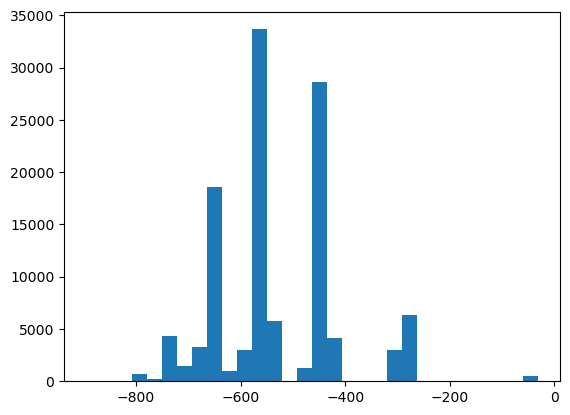

In [47]:
# Making histogram, not using inf values
cluster_post_noinf = np.array([post for post in clusters_all_post if not abs(post)==np.inf])
plt.hist(cluster_post_noinf, bins=30)
plt.show()

In [48]:
# Results
sortidxs=np.argsort(clusters_all_post)
top = 10
print("Total possible clusters: "+str(len(sortidxs)))
print("Ground truth: "+str(cluster_idxs.tolist()))
print("Top clusterings:")
for i, idx in enumerate(np.flip(sortidxs)[:top]):
    print(str(i+1)+": "+str(clusters_all[idx]))

Total possible clusters: 115975
Ground truth: [0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 5.0]
Top clusterings:
1: [0 1 1 1 1 1 1 1 1 1]
2: [0 0 0 0 0 1 0 0 0 0]
3: [0 0 1 1 1 1 1 1 1 1]
4: [0 0 0 0 1 0 0 0 0 0]
5: [0 0 0 0 0 0 0 0 1 0]
6: [0 1 0 0 0 0 0 0 0 0]
7: [0 0 0 1 1 0 0 0 1 0]
8: [0 0 0 1 1 1 0 0 1 0]
9: [0 1 0 1 1 1 1 1 1 1]
10: [0 0 1 0 0 0 0 0 0 0]


In [49]:
# Training
net = GraphNet(n_nodes=adjacency_matrix.size()[0])
X = net.sample_forward(adjacency_matrix=adjacency_matrix)
net.train(X, epochs=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:49<00:00,  8.19s/it]


In [50]:
# Sample
net.termination_chance = 0
X_1000 = []
for i in range(10):
    X = net.sample_forward(adjacency_matrix)
    for x in X:
        clustering = net.get_matrices_from_state(x)[1]
        X_1000.append(torch_posterior(adjacency_matrix, net.get_clustering_list(clustering)[0],
                                        a=torch.tensor([0.5]), b=torch.tensor([0.5]), alpha = 3, log=True)) 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


In [36]:
net.get_clustering_list(clustering)[0]

tensor([1., 0., 2., 3., 1., 1., 2., 4., 4., 1.])

In [51]:
X_1000[:50]

[tensor(-448.0228, dtype=torch.float64),
 tensor(-460.1618, dtype=torch.float64),
 tensor(-674.9656, dtype=torch.float64),
 tensor(-450.1552, dtype=torch.float64),
 tensor(-451.4984, dtype=torch.float64),
 tensor(-462.0497, dtype=torch.float64),
 tensor(-435.2041, dtype=torch.float64),
 tensor(-450.0792, dtype=torch.float64),
 tensor(-457.7919, dtype=torch.float64),
 tensor(-456.5157, dtype=torch.float64),
 tensor(-548.3553, dtype=torch.float64),
 tensor(-483.1275, dtype=torch.float64),
 tensor(-565.1363, dtype=torch.float64),
 tensor(-580.4575, dtype=torch.float64),
 tensor(-295.2716, dtype=torch.float64),
 tensor(-563.7297, dtype=torch.float64),
 tensor(-295.2550, dtype=torch.float64),
 tensor(-552.4110, dtype=torch.float64),
 tensor(-287.3735, dtype=torch.float64),
 tensor(-566.9317, dtype=torch.float64),
 tensor(-297.4503, dtype=torch.float64),
 tensor(-447.4915, dtype=torch.float64),
 tensor(-35.9584, dtype=torch.float64),
 tensor(-446.1136, dtype=torch.float64),
 tensor(-457.5901

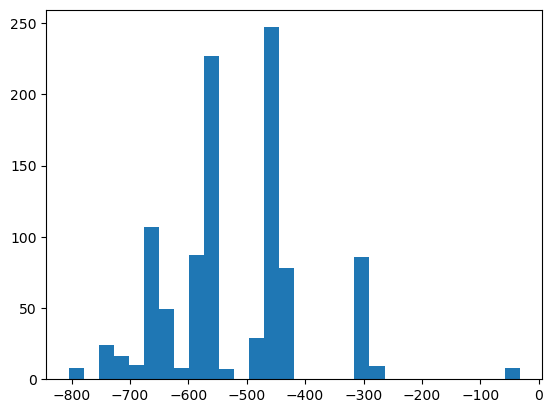

In [52]:
plt.hist(X_1000, bins=30)
plt.show()

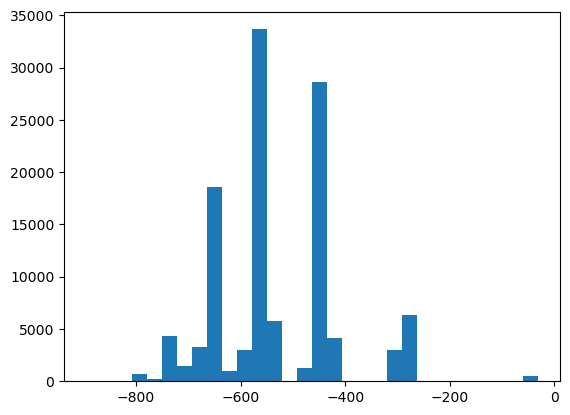

In [53]:
plt.hist(cluster_post_noinf, bins=30)
plt.show()

In [56]:
bestB = np.mean(cluster_post_noinf>-100)
bestG = np.mean(np.array(X_1000)>-100)

print(f'Brute: {bestB}, vs. GFlow: {bestG}')

Brute: 0.00440616000137962, vs. GFlow: 0.008
